# K-means Cluster Heatmaps

In [3]:
import pandas as pd

expression = pd.read_csv("expression.txt", sep="\t")
expression = expression.set_index("Hugo_Symbol")
expression = expression.drop("Entrez_Gene_Id", axis=1)
# print(expression.head())

In [4]:
# patients = pd.read_csv("patient_bchm_recurr_cohorts.csv")
# print(patients.head())
# print()
# bchm_early_pts = patients[patients["Days to Bchm Recurr"]<100]
# bchm_late_pts = patients[patients["Days to Bchm Recurr"]>100]
# bchem_early_ids = bchm_early_pts["Patient (Firehose)"].to_list()
# bchem_late_ids = bchm_late_pts["Patient (Firehose)"].to_list()
# print(bchem_early_ids)
# print()
# print(bchem_late_ids)

In [5]:
patients = pd.read_csv("bchem_cohorts.csv")
print(patients.head())
print()
bchem_c1 = patients[patients["BCHEM_COHORT"]==1]
bchem_c2 = patients[patients["BCHEM_COHORT"]==2]
bchem_c3 = patients[patients["BCHEM_COHORT"]==3]
bchem_c4 = patients[patients["BCHEM_COHORT"]==4]

bchem_c1_ids = bchem_c1["PATIENT_ID"].to_list()
bchem_c2_ids = bchem_c2["PATIENT_ID"].to_list()
bchem_c3_ids = bchem_c3["PATIENT_ID"].to_list()
bchem_c4_ids = bchem_c4["PATIENT_ID"].to_list()
# print(bchem_c1_ids)
# print(bchem_c2_ids)
# print(bchem_c3_ids)
# print(bchem_c4_ids)

     PATIENT_ID  DAYS_TO_BIOCHEMICAL_RECURRENCE_FIRST  BCHEM_COHORT
0  TCGA-ZG-A9L9                                    51             1
1  TCGA-EJ-A65F                                    75             1
2  TCGA-YL-A9WJ                                    76             1
3  TCGA-EJ-5504                                    77             1
4  TCGA-J4-AATZ                                    79             1



In [6]:
# early_bchem = expression[expression.columns.intersection(bchem_early_ids)]
# early_bchem = early_bchem.dropna(axis=0)
# late_bchem = expression[expression.columns.intersection(bchem_late_ids)]
# late_bchem = late_bchem.dropna(axis=0)
# print(early_bchem.head())
# print()
# print(late_bchem.head())

In [7]:
c1_bchem = expression[expression.columns.intersection(bchem_c1_ids)]
c1_bchem = c1_bchem.dropna(axis=0)

c2_bchem = expression[expression.columns.intersection(bchem_c2_ids)]
c2_bchem = c2_bchem.dropna(axis=0)

c3_bchem = expression[expression.columns.intersection(bchem_c3_ids)]
c3_bchem = c3_bchem.dropna(axis=0)

c4_bchem = expression[expression.columns.intersection(bchem_c4_ids)]
c4_bchem = c4_bchem.dropna(axis=0)

# print(c1_bchem.head())
# print()
# print(c2_bchem.head())
# print()
# print(c3_bchem.head())
# print()
# print(c4_bchem.head())

In [8]:
# outliers adjustment code using IQR method (can't use mean method because of large outliers)

def replace_row_outliers_with_median(df: pd.DataFrame, threshold: float = 1.5):
    df_clean = df.copy()
    for index, row in df.iterrows():
        Q1 = row.quantile(0.25)
        Q3 = row.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        median = row.median()
        outliers = (row < lower_bound) | (row > upper_bound)
        # Now update only the outlier *values* in the row
        for col in df.columns:
            if row[col] < lower_bound or row[col] > upper_bound:
                df_clean.at[index, col] = median
    return df_clean

adjusted_c1 = replace_row_outliers_with_median(c1_bchem)
adjusted_c2 = replace_row_outliers_with_median(c2_bchem)
adjusted_c3 = replace_row_outliers_with_median(c3_bchem)
adjusted_c4 = replace_row_outliers_with_median(c4_bchem)

# print(adjusted_c1.head())


In [9]:
# print(c1_bchem.loc["CPLX2"])
# sns.barplot(c1_bchem.loc["CPLX2"])
# print(adjusted_c1.loc["CPLX2"])
# sns.barplot(adjusted_c1.loc["CPLX2"])

In [10]:
adjusted_c1["c1 Average"] = adjusted_c1.mean(axis=1)
# print(early_bchem.head())
adjusted_c2["c2 Average"] = adjusted_c2.mean(axis=1)
# print(late_bchem.head())
adjusted_c3["c3 Average"] = adjusted_c3.mean(axis=1)
adjusted_c4["c4 Average"] = adjusted_c4.mean(axis=1)

expression = pd.DataFrame()
expression["c1 Average"] = adjusted_c1[["c1 Average"]] 
expression["c2 Average"] = adjusted_c2[["c2 Average"]] 
expression["c3 Average"] = adjusted_c3[["c3 Average"]] 
expression["c4 Average"] = adjusted_c4[["c4 Average"]] 
# combined_df = append(late_bchem[["Late Average"]]
print(expression.head())

             c1 Average  c2 Average  c3 Average  c4 Average
Hugo_Symbol                                                
UBE2Q2P2       0.142539   -0.235829    0.743353    0.428489
SSX9          -0.047400   -0.047400   -0.047400   -0.047400
EZHIP         -0.147017   -0.343982   -0.028112    0.001308
EFCAB8         0.004756   -0.190600   -0.078253    0.227289
SDR16C6P      -0.183900   -0.183900   -0.183900   -0.183900


In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram

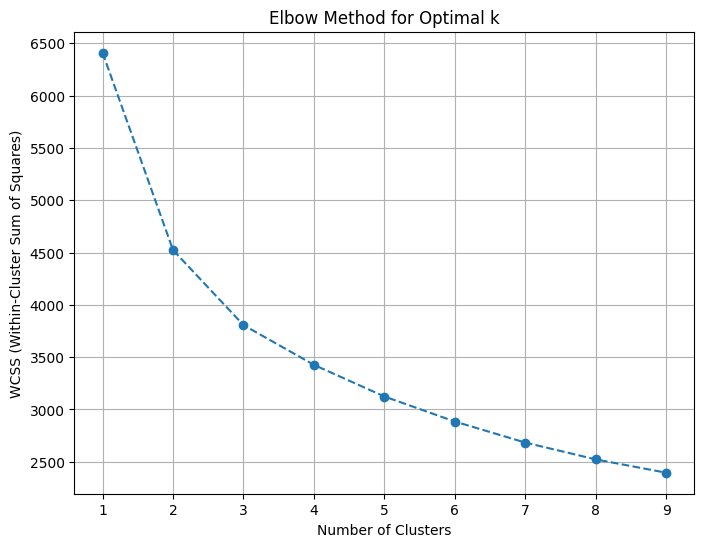

In [12]:
data = expression

# List to store WCSS for each number of clusters
wcss = []

# Loop over possible values of k (number of clusters)
for num_clusters in range(1, 10):  # You can adjust the range based on your data
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    kmeans.fit(data)
    wcss.append(kmeans.inertia_)  # WCSS is stored in inertia_

# Plot the Elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, 10), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.xticks(np.arange(1, 10))
plt.grid(True)
plt.show()

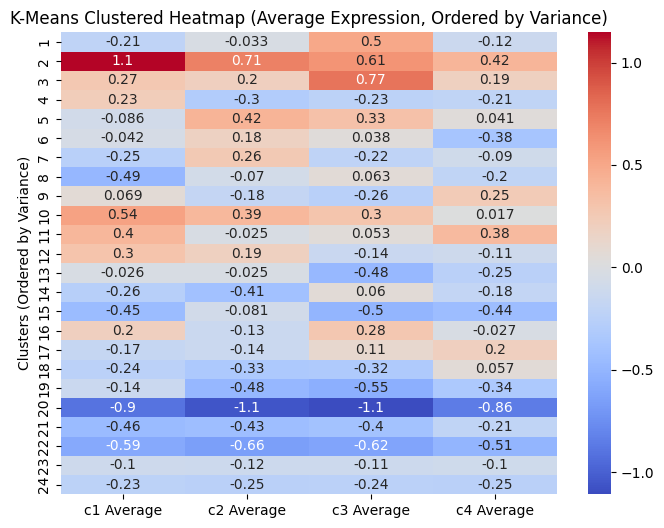

In [13]:
num_clusters = 24
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=40)
clusters = kmeans.fit_predict(data)
data["Cluster"] = clusters

clustered_data = data.groupby("Cluster").mean()

cluster_variances = clustered_data.var(axis=1)

# Sort clusters by variance (highest variance first) and reassign labels
sorted_clusters = cluster_variances.sort_values(ascending=False).index
cluster_mapping = {old: new for new, old in enumerate(sorted_clusters, start=1)}
data["Cluster"] = data["Cluster"].map(cluster_mapping)

clustered_data = clustered_data.loc[sorted_clusters]
clustered_data.index = [cluster_mapping[idx] for idx in clustered_data.index]

# Plot heatmap for averaged clusters
plt.figure(figsize=(8, 6))
sns.heatmap(clustered_data, cmap="coolwarm", xticklabels=True, yticklabels=True, annot=True)

plt.title("K-Means Clustered Heatmap (Average Expression, Ordered by Variance)")
plt.ylabel("Clusters (Ordered by Variance)")
plt.show()

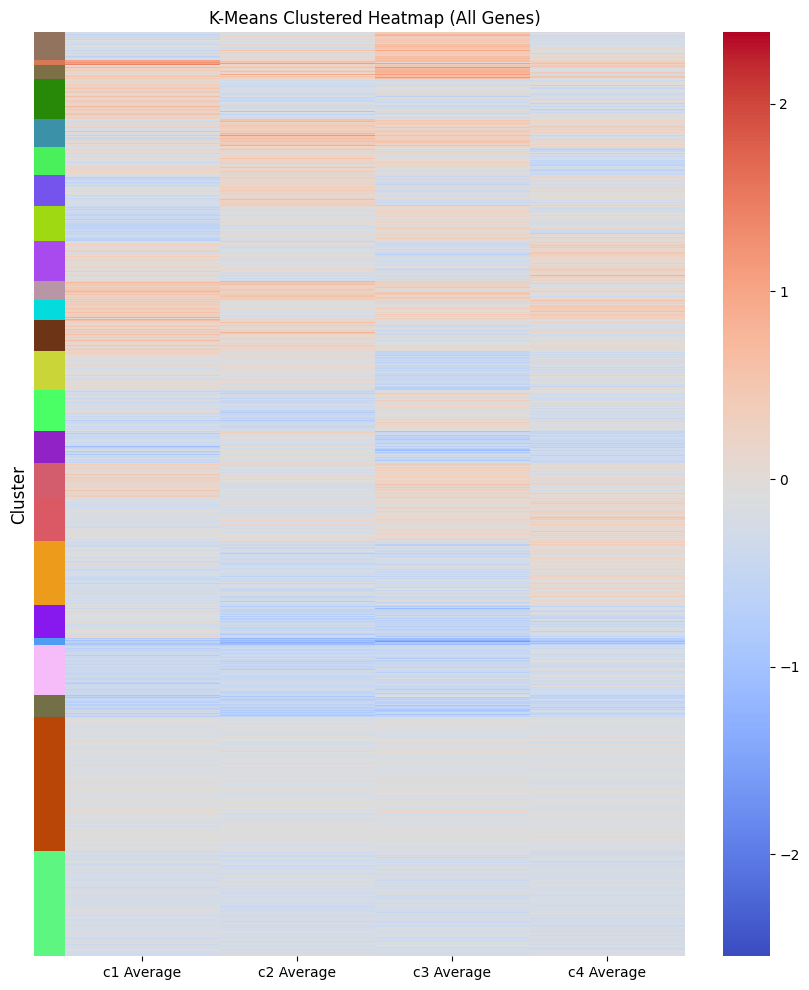

In [14]:
from matplotlib.colors import ListedColormap

# Reorder full dataset by new cluster labels
data_sorted = data.sort_values(by="Cluster")

# Get the number of unique clusters
num_clusters = data_sorted["Cluster"].nunique()

# Generate a random colormap for clusters
random_colors = np.random.rand(num_clusters, 3)  # Random RGB colors
cluster_cmap = ListedColormap(random_colors)  # Create colormap

# Create a figure for both heatmaps
plt.figure(figsize=(10, 12))

# Create a main heatmap for the data (without the cluster column)
sns.heatmap(data_sorted.drop(columns=["Cluster"]), cmap="coolwarm", xticklabels=True, yticklabels=False)

# Create an inset axis for the color bar (cluster labels)
cbar_ax = plt.gca().inset_axes([-0.05, 0, 0.05, 1])  # Thin vertical color bar on the left side

# Plot the cluster labels as a heatmap on the left side using the random colormap
sns.heatmap(data_sorted[['Cluster']], cmap=cluster_cmap, cbar=False, xticklabels=False, yticklabels=False, ax=cbar_ax)

# Add y-axis label for the inset color bar
cbar_ax.set_ylabel('Cluster', fontsize=12)

# Remove any index column label (this is likely where "Unnamed: 0" comes from)
plt.gca().set_ylabel("")  # This removes the y-axis label on the second heatmap

# Adjust layout and finalize the plot
plt.title("K-Means Clustered Heatmap (All Genes)")
plt.show()

In [15]:
# Getting rid of semi-colons for Enrichr

list_of_clusters = []
for cluster_num in range(1, num_clusters + 1): 
    genes_in_cluster = data[data["Cluster"] == cluster_num].index.to_list()
    list_of_clusters.append(genes_in_cluster)
    
j = 1
for cluster in list_of_clusters:
    i = 0
    while i < len(cluster):
        if ';' in cluster[i]:
            split_genes = cluster[i].split(';')
            cluster[i:i+1] = split_genes  # Replace the original gene with the split genes
            i += len(split_genes) - 1  # Skip over the new elements added
        i+=1
#     print(f"Cluster {j}:")
#     print(cluster)
    print(f"Cluster {j} length: " + str(len(cluster)))
    j+=1
    

Cluster 1 length: 551
Cluster 2 length: 95
Cluster 3 length: 294
Cluster 4 length: 795
Cluster 5 length: 542
Cluster 6 length: 561
Cluster 7 length: 615
Cluster 8 length: 693
Cluster 9 length: 808
Cluster 10 length: 367
Cluster 11 length: 408
Cluster 12 length: 624
Cluster 13 length: 765
Cluster 14 length: 824
Cluster 15 length: 643
Cluster 16 length: 690
Cluster 17 length: 861
Cluster 18 length: 1266
Cluster 19 length: 659
Cluster 20 length: 130
Cluster 21 length: 1012
Cluster 22 length: 421
Cluster 23 length: 2686
Cluster 24 length: 2087


# Over-representation Analysis

In [16]:
import gseapy as gp
# human = gp.get_library_name(organism='Human')

# for geneset_library in human:
#     if "hallmark" in geneset_library.lower():
#         print(geneset_library)

# library = gp.get_library(name="GO_Biological_Process_2025", organism="Human")
# print(library.keys())

In [40]:
from IPython.display import display, HTML

cluster = list_of_clusters[19]
print(f"Cluster size: {len(cluster)}")
print()
print(cluster)

enr = gp.enrich(gene_list=cluster, # or gene_list=glist
                 gene_sets=["data/bp_2024.gmt", "data/cc_2024.gmt", "data/mf_2024.gmt", "data/hallmark_2024.gmt", "data/onc_2024.gmt", "data/im_2024.gmt"], # kegg is a dict object
                 background=data.index.to_list(),
                 outdir=None,
                 verbose=False)

display(HTML(enr.results.loc[enr.results["Adjusted P-value"] < 0.05].sort_values(by='Adjusted P-value').to_html()))

Cluster size: 130

['AARS', 'ACSF3', 'ALG5', 'AMFR', 'AP1G1', 'ASAH1', 'ASH2L', 'ATG5', 'ATMIN', 'ATP6V1B2', 'BNIP3L', 'SPRYD7', 'PROSER1', 'PHAF1', 'SMIM15', 'SMIM8', 'TTI2', 'C8orf58', 'CAB39L', 'CBFA2T3', 'CCDC122', 'CCDC25', 'CCNC', 'CDADC1', 'CENPBD1', 'CHMP7', 'CHTF8', 'CLN5', 'CNOT7', 'COG3', 'COG6', 'COG8', 'CREBL2', 'CYB5B', 'DCTN6', 'DDX19A', 'DDX19B', 'DHX38', 'DYNC1LI2', 'ELP3', 'DMTN', 'EPHX2', 'ERI1', 'ERLIN2', 'ESD', 'EXOSC6', 'FA2H', 'FAM160B2', 'FBXO16', 'CMTR2', 'FXR2', 'GLG1', 'GSR', 'HSBP1', 'HSDL1', 'INTS10', 'INTS6', 'INTS9', 'ITM2B', 'KARS', 'KBTBD6', 'KCTD9', 'IST1', 'TLDC1', 'CCAR2', 'KIF13B', 'LEPROTL1', 'LONRF1', 'LYRM2', 'MAK16', 'MAP1LC3B', 'MBTPS1', 'MED4', 'MLYCD', 'MPDU1', 'MPHOSPH6', 'MSRA', 'MTMR9', 'MTUS1', 'NFATC3', 'NHLRC3', 'NUDT15', 'NUDT7', 'NUFIP1', 'PCCA', 'PCM1', 'POLR3D', 'PPP2CB', 'PPP3CC', 'PROSC', 'PSMD7', 'PTEN', 'R3HCC1', 'RARS2', 'RCBTB2', 'RHOBTB2', 'RPL23AP53', 'SDR42E1', 'SETDB2', 'SLC25A30', 'SNX14', 'SORBS3', 'SUCLA2', 'SUGT1', 'TC

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
3439,im_2024.gmt,GSE18804_SPLEEN_MACROPHAGE_VS_TUMORAL_MACROPHAGE_DN,16/177,1.281762e-13,4.943758e-10,16.149999,479.418709,FA2H;HSBP1;DYNC1LI2;MLYCD;CYB5B;HSDL1;IST1;LEPROTL1;MPHOSPH6;TCF25;MBTPS1;ERLIN2;LONRF1;ATMIN;INTS10;INTS9
3436,im_2024.gmt,GSE18804_SPLEEN_MACROPHAGE_VS_BRAIN_TUMORAL_MACROPHAGE_DN,12/172,3.377675e-09,6.513847e-06,11.896171,232.047640,ASH2L;DYNC1LI2;HSDL1;DDX19A;MAP1LC3B;MPHOSPH6;TCF25;ERLIN2;LONRF1;ATMIN;ZDHHC7;TERF2IP
6210,im_2024.gmt,NAKAYA_PBMC_FLUMIST_AGE_18_50YO_7DY_UP,28/1406,4.453990e-07,5.726347e-04,3.405266,49.799609,CREBL2;WDR59;TRIM13;RCBTB2;ATMIN;INTS10;SETDB2;PCM1;ERI1;PPP2CB;NHLRC3;TERF2;CYB5B;DDX19A;GLG1;SUCLA2;VPS36;NFATC3;UTP14C;SUGT1;XPO7;ELP3;WDFY2;GSR;TK2;PCCA;MPDU1;NUDT7
5625,im_2024.gmt,GSE45365_CD8A_DC_VS_CD11B_DC_DN,9/178,4.912250e-06,4.736637e-03,8.345497,102.013505,USP10;VPS37A;LEPROTL1;MPHOSPH6;TCF25;INTS10;ASAH1;TERF2IP;KCTD9
6213,im_2024.gmt,NAKAYA_PLASMACYTOID_DENDRITIC_CELL_FLUMIST_AGE_18_50YO_7DY_UP,22/1125,1.249916e-05,9.641851e-03,3.224293,36.401778,CREBL2;WBP4;WDR59;MSRA;ERLIN2;PTEN;PCM1;PPP2CB;UBE2J1;ALG5;PPP3CC;MAK16;TERF2IP;HSBP1;ESD;DDX19A;SMIM8;R3HCC1;INTS6;COG8;NUDT15;MAP1LC3B
1865,cc_2024.gmt,GOCC_NUCLEAR_PROTEIN_CONTAINING_COMPLEX,21/1179,7.868835e-05,1.046555e-02,2.898597,27.391791,WBP4;MED4;INTS10;ASH2L;ERI1;POLR3D;DDX19B;TERF2IP;TERF2;TNKS;DHX38;EXOSC6;NUFIP1;INTS9;TXNL4B;CHTF8;XPO7;CHMP7;INTS6;MPHOSPH6;CCNC
1813,cc_2024.gmt,GOCC_GOLGI_TRANSPORT_COMPLEX,3/10,3.994616e-05,1.046555e-02,66.810196,676.652192,COG3;COG8;COG6
1816,cc_2024.gmt,GOCC_INTEGRATOR_COMPLEX,3/14,1.186851e-04,1.052341e-02,43.562319,393.761400,INTS10;INTS9;INTS6
425,bp_2024.gmt,GOBP_LATE_ENDOSOME_TO_VACUOLE_TRANSPORT_VIA_MULTIVESICULAR_BODY_SORTING_PATHWAY,4/26,3.159221e-05,1.559434e-02,28.835573,298.811509,VPS37A;VPS36;LEPROTL1;CHMP7
459,bp_2024.gmt,GOBP_MACROMOLECULE_CATABOLIC_PROCESS,23/1297,3.662792e-05,1.559434e-02,2.913557,29.761106,CNOT7;ERLIN2;AMFR;FXR2;PTEN;PSMD7;ERI1;ATG5;PPP2CB;UBE2J1;NHLRC3;ZC3H18;BNIP3L;CBFA2T3;CCAR2;VPS37A;EXOSC6;VPS36;CHMP7;CLN5;NUDT15;TRIM13;KBTBD6


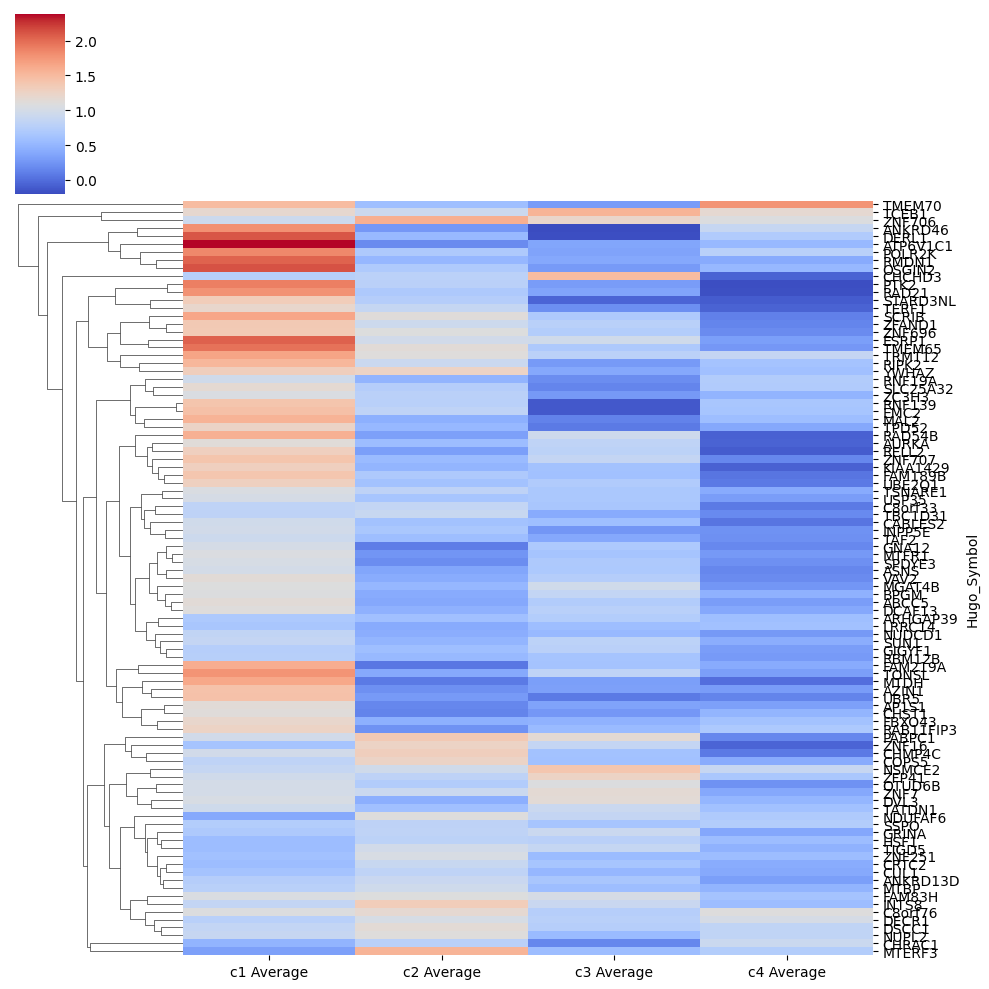

In [29]:
sns.clustermap(data_sorted.loc[cluster].drop(columns=["Cluster"]), cmap="coolwarm", xticklabels=True, yticklabels=True, annot=False, col_cluster = False)


In [30]:
adjusted_c1.columns = ["1"] * len(adjusted_c1.columns)
adjusted_c2.columns = ["2"] * len(adjusted_c2.columns)
adjusted_c3.columns = ["3"] * len(adjusted_c3.columns)
adjusted_c4.columns = ["4"] * len(adjusted_c4.columns)
print(adjusted_c1.head())

                  1       1       1       1       1       1       1       1  \
Hugo_Symbol                                                                   
UBE2Q2P2    -0.5443  0.0453 -0.0651  0.9005  0.0184  1.9077 -0.7704 -0.6849   
SSX9        -0.0474 -0.0474 -0.0474 -0.0474 -0.0474 -0.0474 -0.0474 -0.0474   
EZHIP       -0.0684 -0.5459 -0.2836 -0.7616  0.7517 -0.7616 -0.3635 -0.1523   
EFCAB8      -0.4290 -0.1805 -0.4290 -0.2365 -0.2111  0.6982  0.2590 -0.4290   
SDR16C6P    -0.1839 -0.1839 -0.1839 -0.1839 -0.1839 -0.1839 -0.1839 -0.1839   

                  1        1       1        1       1       1       1       1  \
Hugo_Symbol                                                                     
UBE2Q2P2     0.7732  0.01090  0.5965 -0.22340  0.0259  0.5946 -0.0795  0.9356   
SSX9        -0.0474 -0.04740 -0.0474 -0.04740 -0.0474 -0.0474 -0.0474 -0.0474   
EZHIP       -0.3227 -0.10640  0.7552 -0.76160 -0.1523 -0.0951 -0.3083 -0.1982   
EFCAB8       0.3296  0.03925  0.4448  0.0

/home/srifai/HussainLab/GNN_Cancer/.venv/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


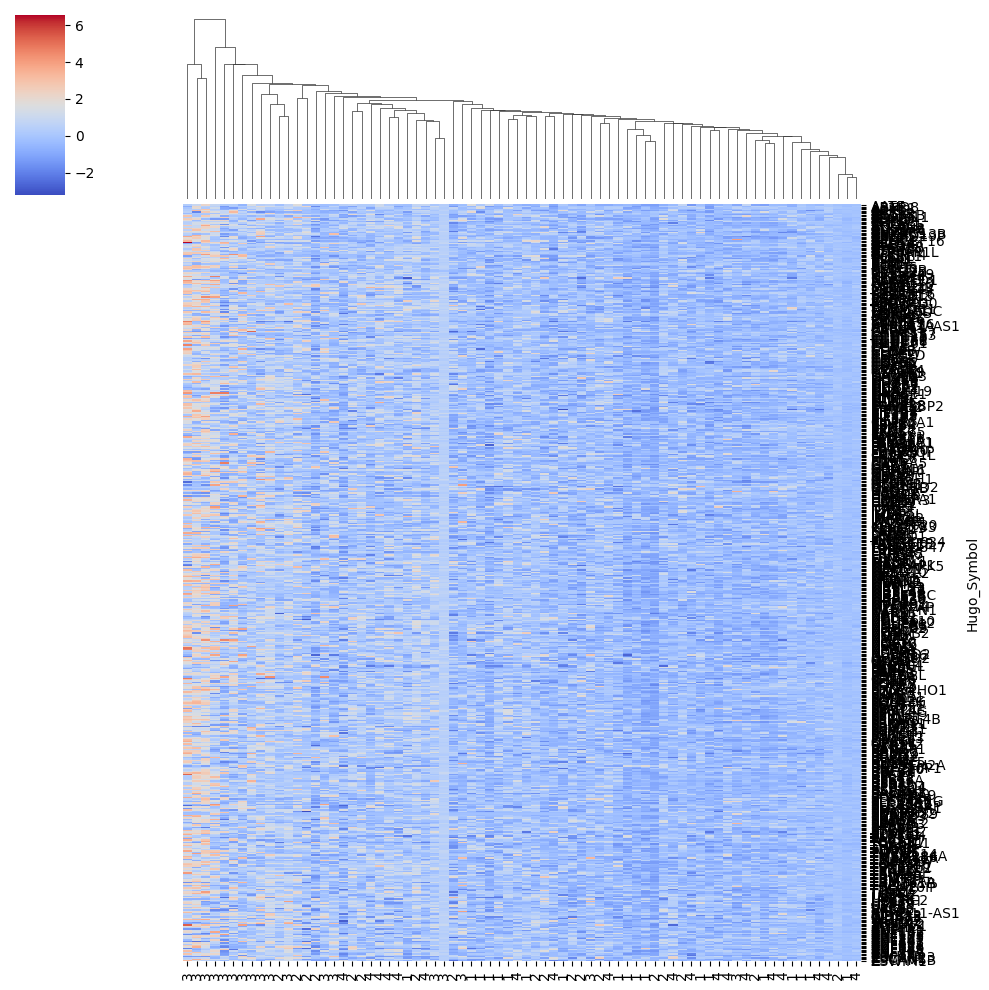

In [20]:
parent_bchem = pd.DataFrame()
parent_bchem = pd.concat([adjusted_c1, adjusted_c2, adjusted_c3, adjusted_c4], axis = 1)
drop_cols = [col for col in parent_bchem.columns if "Average" in col]
parent_bchem = parent_bchem.drop(columns = drop_cols, axis=1)
# print(parent_bchem.head())
sns.clustermap(parent_bchem.loc[cluster], cmap="coolwarm", xticklabels=True, yticklabels=True, annot=False, row_cluster=False)

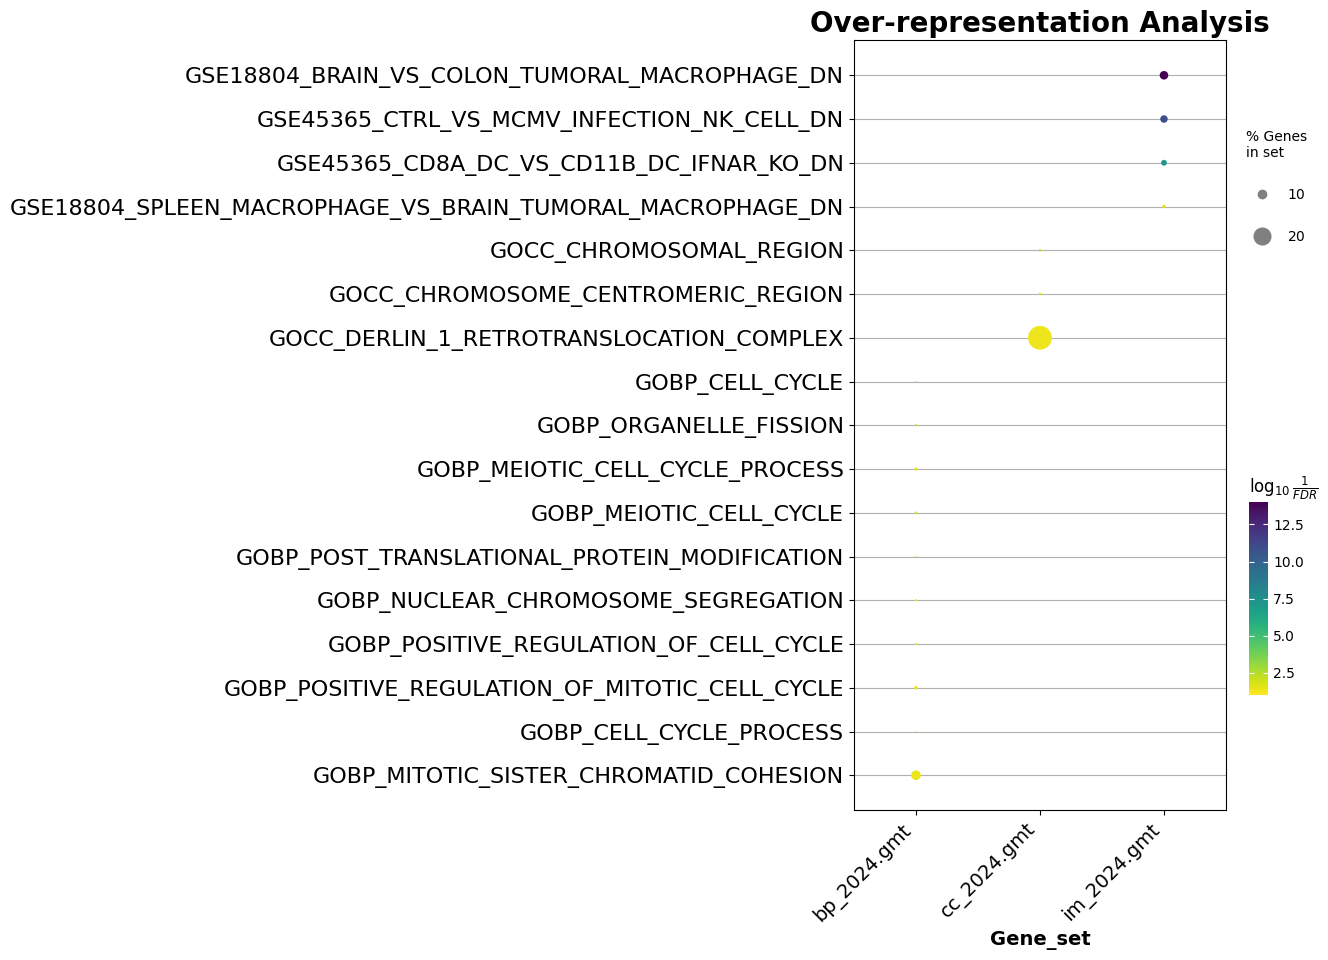

In [31]:
from gseapy import barplot, dotplot
ax = dotplot(enr.results,
              column="Adjusted P-value",
              x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
              size=10,
              top_term=10,
              figsize=(6,10),
              title = "Over-representation Analysis",
              xticklabels_rot=45, # rotate xtick labels
              show_ring=False, # set to False to revmove outer ring
              marker='o',
             )

In [35]:
parent_bchem_T = parent_bchem.loc[cluster].T
print(parent_bchem_T.head())
# # Remove columns with repeated names
# total_data = data.loc[:, ~parent_bchem.columns.duplicated()]

# # Drop non-numeric columns (assuming the first 3 columns are metadata)
# gene_expression = total_data.iloc[:, 0:]  # Exclude the label column

# Convert to numpy array
parent_bchem_T_vals = parent_bchem_T.values

print(parent_bchem_T_vals)

Hugo_Symbol   ABCC5  ANKRD13D  ANKRD46   AP1S1  ARHGAP39    ASNS  ATP6V1C1  \
1           -0.7252   -1.2668   2.7683  0.4290   -0.9828 -0.7362    0.6720   
1            0.8817   -0.4295   0.6315 -0.7396   -0.6482  1.1690    0.7086   
1            1.3921   -0.8180   0.1717 -1.2547   -0.0961 -0.8321    0.2885   
1            0.9444   -0.4305   2.5565 -0.3818    2.0936 -0.4298    2.3385   
1           -0.1557    0.0651   0.3805 -0.2620    0.1426 -1.0260    0.1137   

Hugo_Symbol   AURKA   AZIN1    BPGM  ...   YWHAZ   ZC3H3  ZFAND1   ZFP41  \
1            0.1335  2.7425  0.4553  ...  0.8805 -0.9899  0.5890 -0.6012   
1            0.7525  1.6967  0.7564  ...  1.6085  0.8954 -0.0850  1.0422   
1            0.1259  0.2590 -0.4879  ... -0.4385 -0.0817  0.2469  0.8371   
1           -0.4004  1.1492 -0.6439  ...  1.4495  1.5872  1.2143  2.0283   
1           -1.0390 -0.7619 -0.5161  ... -1.0708 -0.0545 -0.4657  0.7463   

Hugo_Symbol   ZNF16  ZNF251  ZNF696  ZNF706  ZNF707    ZNF7  
1           

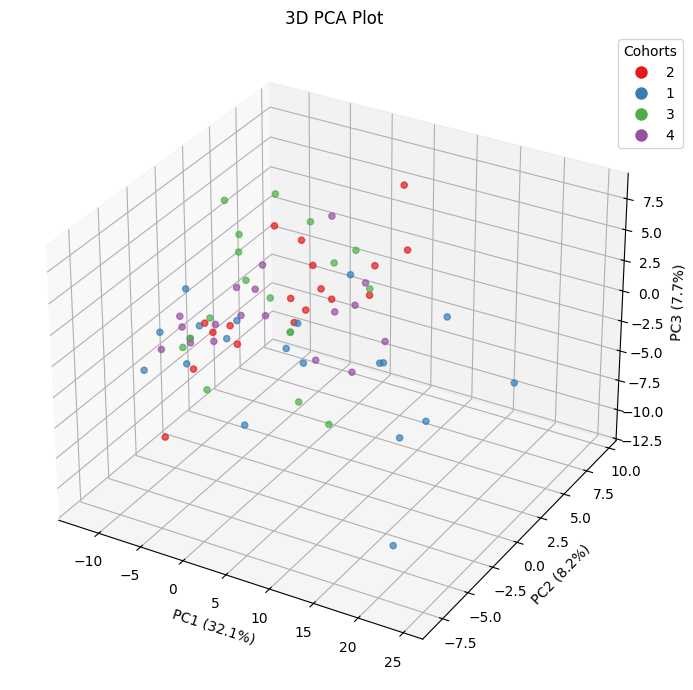

In [36]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=3)
gene_expression_pca = pca.fit_transform(parent_bchem_T_vals)

# Get % variance explained
explained_var = pca.explained_variance_ratio_ * 100  # convert to percent

# Get cohort labels
cohorts = parent_bchem.columns
unique_labels = list(set(cohorts))
color_map = {label: color for label, color in zip(unique_labels, plt.cm.Set1.colors)}
colors = cohorts.map(color_map)

# Create 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot PCA
scatter = ax.scatter(
    gene_expression_pca[:, 0],
    gene_expression_pca[:, 1],
    gene_expression_pca[:, 2],
    c=colors, alpha=0.7
)

ax.set_xlabel(f'PC1 ({explained_var[0]:.1f}%)')
ax.set_ylabel(f'PC2 ({explained_var[1]:.1f}%)')
ax.set_zlabel(f'PC3 ({explained_var[2]:.1f}%)')
ax.set_title('3D PCA Plot')

# Legend
legend_patches = [
    plt.Line2D([0], [0], marker='o', color='w', label=label, markersize=10, markerfacecolor=color)
    for label, color in color_map.items()
]
ax.legend(handles=legend_patches, title='Cohorts', loc='best', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()


/tmp/ipykernel_98694/2152845138.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap("Set1", len(unique_labels))


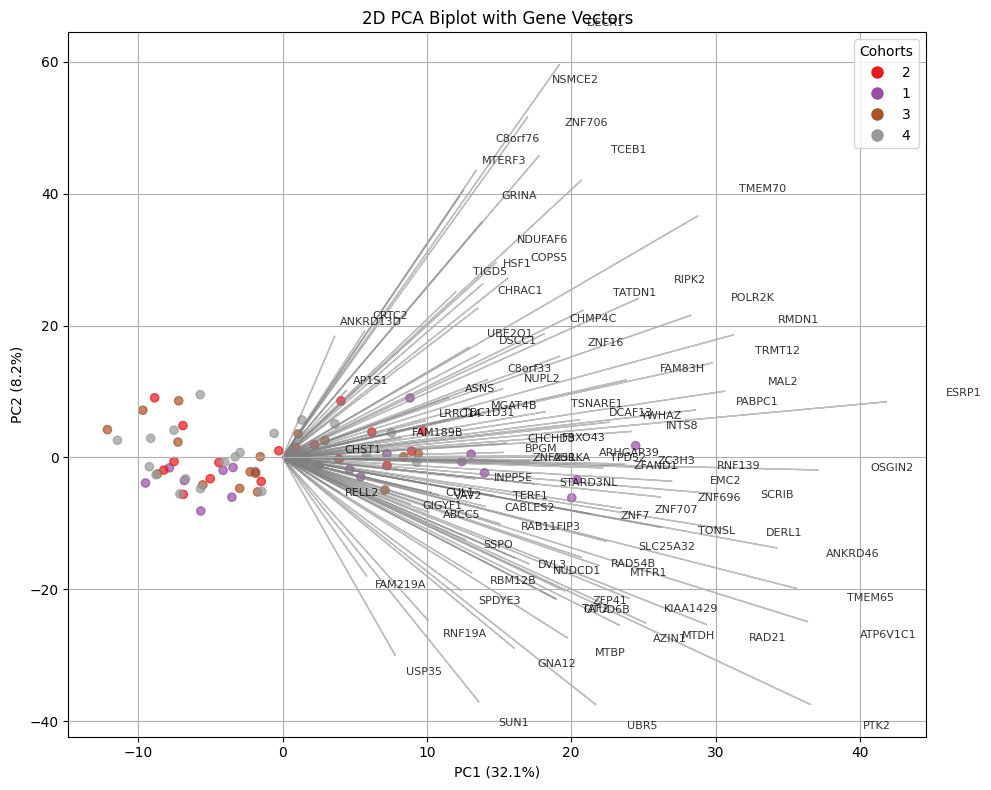

In [37]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

# Run PCA on the transposed data (samples as rows)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(parent_bchem_T_vals)

# Get variance explained
explained_var = pca.explained_variance_ratio_ * 100

# Get cohorts and assign high-contrast colors
cohorts = parent_bchem.columns
unique_labels = list(set(cohorts))
colormap = plt.cm.get_cmap("Set1", len(unique_labels))
color_map = {label: colormap(i) for i, label in enumerate(unique_labels)}
colors = cohorts.map(color_map)

# Plot 2D scatter plot with PCA results
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], c=colors, alpha=0.7)

# Axis labels
ax.set_xlabel(f'PC1 ({explained_var[0]:.1f}%)')
ax.set_ylabel(f'PC2 ({explained_var[1]:.1f}%)')
ax.set_title('2D PCA Biplot with Gene Vectors')

# Add gene vectors (loadings)
loadings = pca.components_.T  # shape: (n_genes, 2)
genes = parent_bchem_T.columns  # gene names

# Scale vectors for visibility
scale_factor = 200

for i, gene in enumerate(genes):
    ax.arrow(0, 0, 
             loadings[i, 0] * scale_factor, 
             loadings[i, 1] * scale_factor, 
             color='gray', alpha=0.5, head_width=0.05)
    ax.text(loadings[i, 0] * scale_factor * 1.1, 
            loadings[i, 1] * scale_factor * 1.1, 
            gene, fontsize=8, alpha=0.8)

# Custom legend
legend_patches = [
    plt.Line2D([0], [0], marker='o', color='w', label=label, 
               markersize=10, markerfacecolor=color)
    for label, color in color_map.items()
]
ax.legend(handles=legend_patches, title='Cohorts', loc='best')

plt.grid(True)
plt.tight_layout()
plt.show()


In [27]:
print(len(parent_bchem.columns))

74
